TRAIN_DIR: C:\Users\lenovo\OneDrive\Bureau\Cycle 2\S1\Deep Learning\Projet\FaceMaskDataset\FaceMaskDataset\train224
TEST_DIR : C:\Users\lenovo\OneDrive\Bureau\Cycle 2\S1\Deep Learning\Projet\FaceMaskDataset\FaceMaskDataset\test224
Found 5944 files belonging to 2 classes.
Using 4756 files for training.
Found 5944 files belonging to 2 classes.
Using 1188 files for validation.
Found 3060 files belonging to 2 classes.
Classes : ['face', 'maskface']


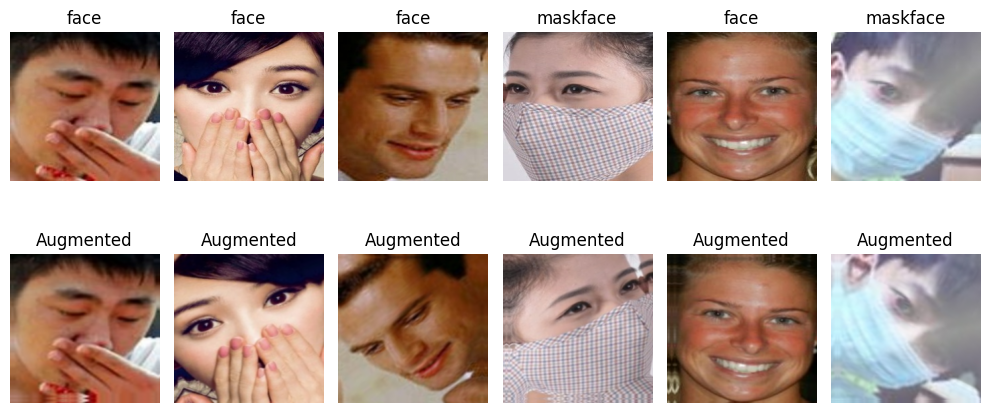

In [1]:
from load import load_data

train_ds, val_ds, test_ds, class_names, data_augmentation, IMG_SIZE, BATCH_SIZE = load_data(show_examples=True)

In [2]:
import os
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPUs disponibles :", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
GPUs disponibles : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Construction du Modèle 1 (CNN baseline)

Dans cette cellule, on définit un **premier modèle CNN simple** servant de baseline.  
Voici les choix principaux :

- **Entrée** : images de taille `IMG_SIZE` avec 3 canaux (RGB).
- **Data augmentation** : appliquée uniquement durant l’entraînement pour améliorer la robustesse du modèle.
- **Normalisation** : `Rescaling(1./255)` pour ramener les pixels dans l’intervalle [0, 1].

- **Architecture du réseau**
  - **Bloc 1** :  
    - Conv2D (32 filtres, kernel 3×3, ReLU)  
    - MaxPooling2D (2×2)
  - **Bloc 2** :  
    - Conv2D (64 filtres)  
    - MaxPooling2D
  - **Bloc 3** :  
    - Conv2D (128 filtres)  
    - MaxPooling2D

  Ces 3 blocs permettent d’extraire progressivement des caractéristiques de plus en plus complexes.

- **Classification**
  - Flatten → transformation en vecteur  
  - Dense(128, ReLU) → couche fully connected  
  - Dropout(0.5) → réduit le surapprentissage  
  - Dense(1, sigmoid) → sortie binaire (`maskface` / `face`)

- **Résumé**
  Le modèle reste volontairement léger, rapide à entraîner et sert de **référence de base** pour comparer les modèles plus avancés (CNN profond, ResNet, EfficientNet…).


In [3]:
from tensorflow import keras
from tensorflow.keras import layers

input_shape = IMG_SIZE + (3,)

model1 = keras.Sequential(
    [
        layers.Input(shape=input_shape),

        # Data augmentation (uniquement en mode training)
        data_augmentation,

        # Normalisation [0, 1]
        layers.Rescaling(1./255),

        # Bloc 1
        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        # Bloc 2
        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        # Bloc 3
        layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid")  # binaire : mask / no mask
    ],
    name="cnn_baseline"
)


model1.summary()

Model: "cnn_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)      

## Compilation du modèle et callbacks

On utilise :

- `Adam` comme optimiseur,
- `binary_crossentropy` comme fonction de perte,
- des métriques : accuracy, précision, rappel,
- des callbacks :
  - `EarlyStopping` pour arrêter si la val_loss ne s'améliore plus,
  - `ReduceLROnPlateau` pour diminuer le learning rate.


In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ],
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1
)
checkpointer = ModelCheckpoint(
    "models/best_model.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

##  Entraînement du modèle 1

On entraîne le modèle sur l'ensemble d'entraînement et on suit les performances sur validation.


In [5]:
EPOCHS = 20

history1 = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr, checkpointer]
)

Epoch 1/20
298/298 [==============================] - ETA: 0s - loss: 0.3772 - accuracy: 0.8556 - precision: 0.8748 - recall: 0.8269
Epoch 1: val_loss improved from inf to 0.25353, saving model to models\best_model.h5
298/298 [==============================] - 58s 146ms/step - loss: 0.3772 - accuracy: 0.8556 - precision: 0.8748 - recall: 0.8269 - val_loss: 0.2535 - val_accuracy: 0.9007 - val_precision: 0.8926 - val_recall: 0.9187 - lr: 0.0010
Epoch 2/20
298/298 [==============================] - ETA: 0s - loss: 0.2956 - accuracy: 0.8907 - precision: 0.9030 - recall: 0.8731
Epoch 2: val_loss did not improve from 0.25353
298/298 [==============================] - 36s 122ms/step - loss: 0.2956 - accuracy: 0.8907 - precision: 0.9030 - recall: 0.8731 - val_loss: 0.2580 - val_accuracy: 0.9015 - val_precision: 0.8903 - val_recall: 0.9236 - lr: 0.0010
Epoch 3/20
298/298 [==============================] - ETA: 0s - loss: 0.2841 - accuracy: 0.8968 - precision: 0.9107 - recall: 0.8778
Epoch 3: va

##  Courbes d'apprentissage (accuracy et loss)

On trace l'évolution de la **loss** et de l'**accuracy** sur train et validation pour analyser le comportement du modèle (overfitting, underfitting, etc.).

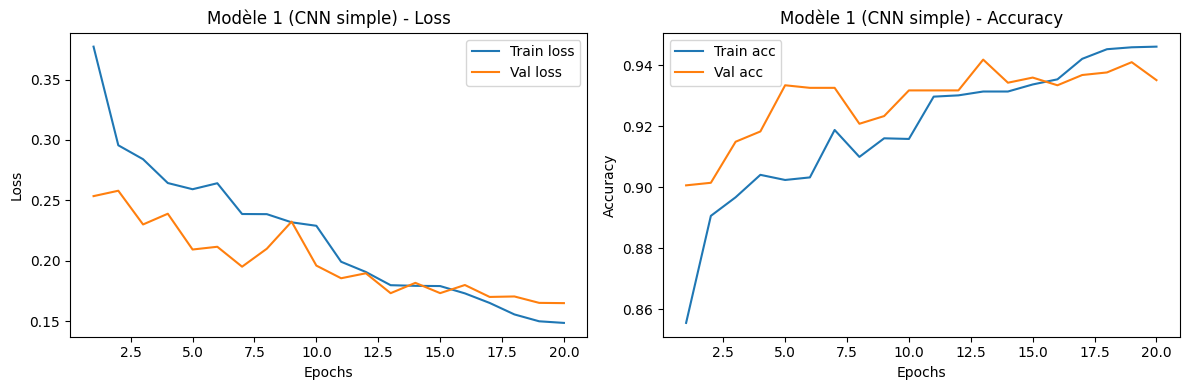

In [6]:
import matplotlib.pyplot as plt

def plot_history(history, title_prefix="Modèle 1"):
    hist = history.history

    epochs_range = range(1, len(hist["loss"]) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, hist["loss"], label="Train loss")
    plt.plot(epochs_range, hist["val_loss"], label="Val loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, hist["accuracy"], label="Train acc")
    plt.plot(epochs_range, hist["val_accuracy"], label="Val acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_history(history1, title_prefix="Modèle 1 (CNN simple)")


##  Évaluation sur l'ensemble de test

On mesure les performances finales sur `test_ds` :

- loss
- accuracy
- précision
- rappel

In [7]:
test_results1 = model1.evaluate(test_ds, verbose=1)
print("\nRésultats sur le test (Modèle 1) :")
for name, value in zip(model1.metrics_names, test_results1):
    print(f"{name}: {value:.4f}")

192/192 [==============================] - 6s 29ms/step - loss: 0.1880 - accuracy: 0.9395 - precision: 0.8856 - recall: 0.9443

Résultats sur le test (Modèle 1) :
loss: 0.1880
accuracy: 0.9395
precision: 0.8856
recall: 0.9443


## Matrice de confusion et rapport de classification

On calcule :

- la matrice de confusion,
- le rapport de classification (precision, recall, F1-score par classe).

Cela permet d'analyser plus finement les erreurs du modèle (par exemple : confond-il souvent *with mask* et *without mask* ?).


In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Récupérer toutes les vraies étiquettes
y_true = []
for _, labels in test_ds:
    y_true.append(labels.numpy())

y_true = np.concatenate(y_true, axis=0)

# Prédictions
y_pred_proba = model1.predict(test_ds)
y_pred = (y_pred_proba.ravel() > 0.5).astype(int)

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Rapport de classification
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


192/192 [==============================] - 3s 14ms/step
Confusion Matrix:
 [[1892  127]
 [  58  983]]

Classification Report:
              precision    recall  f1-score   support

        face       0.97      0.94      0.95      2019
    maskface       0.89      0.94      0.91      1041

    accuracy                           0.94      3060
   macro avg       0.93      0.94      0.93      3060
weighted avg       0.94      0.94      0.94      3060



### Interprétation des résultats – Modèle 1 (CNN baseline)

- **Performance globale**  
  - `accuracy ≈ 93,95 %`  
  - `loss = 0.188`  
  → Le modèle de base (CNN simple) arrive déjà à bien séparer les deux classes *face* / *maskface*.

- **Précision et rappel par classe**

  - **Classe `face` (sans masque)**  
    - precision = **0.97**  
    - recall = **0.94**  
    → Le modèle reconnaît très bien les visages sans masque et fait peu d’erreurs de classification sur cette classe.

  - **Classe `maskface` (avec masque)**  
    - precision = **0.89**  
    - recall = **0.94**  
    → Le modèle détecte correctement la plupart des visages masqués (bon rappel), mais il fait plus de faux positifs (des *face* prédits comme *maskface*).

- **Lecture de la matrice de confusion**

  - TN (face → face) = **1892**  
  - FP (face → maskface) = **127**  
  - FN (maskface → face) = **58**  
  - TP (maskface → maskface) = **983**

  → Les erreurs principales sont :
  - **127 visages sans masque** prédits comme *maskface* (faux positifs),  
  - **58 visages avec masque** prédits comme *face* (faux négatifs).

- **Conclusion pour le Modèle 1**

  Ce CNN simple constitue une **baseline solide** :
  - bonne accuracy globale,
  - métriques équilibrées entre les deux classes,
  - légère faiblesse en **précision sur la classe `maskface`**.

  Les modèles suivants (CNN profond, ResNet, EfficientNet, etc.) devront chercher à :
  - **réduire les faux positifs sur `maskface`** (améliorer la précision),
  - tout en **gardant un rappel élevé** pour ne pas rater les visages masqués.
